In [1]:
import numpy as np
import pandas as pd
import pickle
import torch
import torch.nn as nn
import os
from copy import deepcopy
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler
from itertools import permutations
import torch.nn.functional as F
# from tqdm import tqdm
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import vector
from tqdm.notebook import tqdm


In [2]:
#load data
base_path = os.path.dirname(os.getcwd())

full_folder_path = os.path.join(base_path,"saved_files", "fake_data")
# data_df=pd.read_pickle(os.path.join(full_folder_path,"Aug7_1mil.pkl"))
with open(os.path.join(full_folder_path,"Aug7_1mil.pkl"), 'rb') as f:
    clean_data_dict = pickle.load(f)
print(clean_data_dict.keys())
numevents=len(clean_data_dict['2_phi'])
print("number of events:",numevents)

data_dict=clean_data_dict
print(data_dict.keys())

data_dict_np={}
for key in data_dict.keys():
    data_dict_np[key]=np.array(data_dict[key])


# output features: deltaphi, deltaeta, deltaR, m_t,  norm_mt, mass, pt, eta , phi*(maybe dont use),  px, py, pz, energy


dict_keys(['event', 'genWeight', 'MET_phi', '1_phi', '1_genPartFlav', '2_phi', '2_genPartFlav', '3_phi', '3_genPartFlav', 'charge_1', 'charge_2', 'charge_3', 'pt_1', 'pt_2', 'pt_3', 'pt_MET', 'eta_1', 'eta_2', 'eta_3', 'mass_1', 'mass_2', 'mass_3', 'deltaphi_12', 'deltaphi_13', 'deltaphi_23', 'deltaphi_1MET', 'deltaphi_2MET', 'deltaphi_3MET', 'deltaphi_1(23)', 'deltaphi_2(13)', 'deltaphi_3(12)', 'deltaphi_MET(12)', 'deltaphi_MET(13)', 'deltaphi_MET(23)', 'deltaphi_1(2MET)', 'deltaphi_1(3MET)', 'deltaphi_2(1MET)', 'deltaphi_2(3MET)', 'deltaphi_3(1MET)', 'deltaphi_3(2MET)', 'deltaeta_12', 'deltaeta_13', 'deltaeta_23', 'deltaeta_1(23)', 'deltaeta_2(13)', 'deltaeta_3(12)', 'deltaR_12', 'deltaR_13', 'deltaR_23', 'deltaR_1(23)', 'deltaR_2(13)', 'deltaR_3(12)', 'pt_123', 'mt_12', 'mt_13', 'mt_23', 'mt_1MET', 'mt_2MET', 'mt_3MET', 'mt_1(23)', 'mt_2(13)', 'mt_3(12)', 'mt_MET(12)', 'mt_MET(13)', 'mt_MET(23)', 'mt_1(2MET)', 'mt_1(3MET)', 'mt_2(1MET)', 'mt_2(3MET)', 'mt_3(1MET)', 'mt_3(2MET)', 'ma

In [3]:
input_data_names_ordered = [
    ['MET_phi', 'pt_MET'], 
    ['1_phi', 'charge_1', 'pt_1', 'eta_1', 'mass_1'], 
    ['2_phi', 'charge_2', 'pt_2', 'eta_2', 'mass_2'], 
    ['3_phi', 'charge_3', 'pt_3', 'eta_3', 'mass_3']
]
input_data_particle_order = ['MET', '1', '2', '3']

pair_order = ["MET_1", "MET_2", "MET_3", "1_2", "1_3", "2_3"]
used_labels2 = [
    ['deltaphi_1MET', 'mt_1MET'], 
    ['deltaphi_2MET', 'mt_2MET'], 
    ['deltaphi_3MET', 'mt_3MET'], 
    ['deltaphi_12', 'deltaeta_12', 'deltaR_12', 'mt_12', 'norm_mt_12'], 
    ['deltaphi_13', 'deltaeta_13', 'deltaR_13', 'mt_13', 'norm_mt_13'], 
    ['deltaphi_23', 'deltaeta_23', 'deltaR_23', 'mt_23', 'norm_mt_23']
]

lepton_input_ordered = input_data_names_ordered[1:]
lepton_output_ordered = used_labels2[3:]

l_input_shape=(numevents,len(lepton_input_ordered), len(lepton_input_ordered[0]))
print("events, particles, input features: ",l_input_shape)
l_input= np.empty(l_input_shape)

for i in range(len(lepton_input_ordered)):
    for j, feature in enumerate(lepton_input_ordered[i]):
        l_input[:,i,j] = data_dict_np[feature]

l_output_shape=(numevents, len(lepton_output_ordered), len(lepton_output_ordered[0]))
print("events, particle pairs, output kin. features: ",l_output_shape)
l_output= np.empty(l_output_shape)

for i in range(len(lepton_output_ordered)):
    for j, feature in enumerate(lepton_output_ordered[i]):
        l_output[:,i,j] = data_dict_np[feature]

lepton_pair_order = pair_order[3:]
lepton_particle_order = input_data_particle_order[1:]
print("lepton pair order: ", lepton_pair_order)
print("lepton particle order: ", lepton_particle_order)

events, particles, input features:  (568554, 3, 5)
events, particle pairs, output kin. features:  (568554, 3, 5)
lepton pair order:  ['1_2', '1_3', '2_3']
lepton particle order:  ['1', '2', '3']


In [4]:
def add_extra_features(data):
    p1_pt=data['pt_1']
    p2_pt=data['pt_2']
    p3_pt=data['pt_3']

    p1_phi=data["1_phi"]
    p2_phi=data["2_phi"]
    p3_phi=data["3_phi"]

    p1_eta=data["eta_1"]
    p2_eta=data["eta_2"]
    p3_eta=data["eta_3"]

    p1_mass=data["mass_1"]
    p2_mass=data["mass_2"]
    p3_mass=data["mass_3"]

    particle1=vector.arr({"pt": p1_pt, "phi": p1_phi, "eta": p1_eta, "mass": p1_mass})
    particle2=vector.arr({"pt": p2_pt, "phi": p2_phi, "eta": p2_eta, "mass": p2_mass})
    particle3=vector.arr({"pt": p3_pt, "phi": p3_phi, "eta": p3_eta, "mass": p3_mass})

    p4_mother12=particle1+particle2
    p4_mother23=particle2+particle3
    p4_mother13=particle1+particle3

    pairs=['12','13','23']
    motherpairs=[p4_mother12, p4_mother13, p4_mother23]
    features_toadd=[ 'mass', 'pt', 'eta' , 'phi',  'px', 'py', 'pz', 'energy']
    # features_toadd=[ 'mass', 'pt', 'eta' , 'phi',  'px', 'py', 'pz']

    add_feat_size=(len(data['pt_1']), len(pairs), len(features_toadd))
    add_feat_array= np.empty(add_feat_size)

    for feature in features_toadd:
        for i, pair in enumerate(pairs):
           add_feat_array[:, i, features_toadd.index(feature)] = getattr(motherpairs[i], feature)
    return add_feat_array

    
    # for i, pair in enumerate(pairs):
    #     features_toadd=[ 'mass', 'pt', 'eta' , 'phi',  'px', 'py', 'pz', 'energy']
    #     for feature in features_toadd:
    #         data['mother_' + feature + '_' + pair] = motherpairs[i].feature
    # return data

data_conc=add_extra_features(data_dict_np)
print(data_conc.shape)
# print(data_new.columns)
l_output2= np.concatenate((l_output, data_conc), axis=2)
print("l_output new shape: ",l_output2.shape)


(568554, 3, 8)
l_output new shape:  (568554, 3, 13)


## normalizing ##

In [5]:
def normalize_l(data):
    # l_input_reshaped=l_input.reshape(l_input.shape[0], -1)
    # print("input reshaped shape:",l_input_reshaped.shape)
    # scaler = StandardScaler()
    # data_normalized = scaler.fit_transform(l_input_reshaped)

    means = data.mean(axis=(0))
    stds = data.std(axis=(0))
    # print("means shape:",means.shape)

    data_normalized = (data - means) / (stds + 1e-10)
    return data_normalized, means, stds

n_l_input, _, _ = normalize_l(l_input)
print("normalized input shape:",n_l_input.shape)


n_l_output, l_output_means, l_output_stds = normalize_l(l_output2)
print("normalized output shape:",n_l_output.shape)

def invert_normalize(data_normalized, means, stds):
    return (data_normalized * stds) + means



normalized input shape: (568554, 3, 5)
normalized output shape: (568554, 3, 13)


## Converting to tensor and adding pairs ##

In [6]:
linput_tensor = torch.tensor(n_l_input, dtype=torch.float32)
llabel_tensor = torch.tensor(n_l_output, dtype=torch.float32)

lpairs_data=[]
lpairs_labels=[]

# lepton_pair_order = ['1_2', '1_3', '2_3']
lepton_pair_mapping={(0,1): lepton_pair_order.index('1_2'), (0,2): lepton_pair_order.index('1_3'), (1,2): lepton_pair_order.index('2_3')}

for key, value in lepton_pair_mapping.items():
    concatonated_data=torch.cat((linput_tensor[:,key[0],:], linput_tensor[:,key[1],:]), dim=1)
    lpairs_data.append(concatonated_data)

    lpairs_labels.append(llabel_tensor[:,value,:])

print(len(lpairs_data), len(lpairs_labels))
print(lpairs_data[0].shape, lpairs_labels[0].shape)

3 3
torch.Size([568554, 10]) torch.Size([568554, 13])


## Making training data ##

In [7]:
train_data_list = []
val_data_list = []
test_data_list = []
train_labels_list = []
val_labels_list = []
test_labels_list = []

for pair_idx in range(len(lpairs_data)):
    pair_data = lpairs_data[pair_idx]
    pair_labels = lpairs_labels[pair_idx]

    train_val_data, test_data, train_val_labels, test_labels = train_test_split(pair_data, pair_labels, test_size=0.2, random_state=42)
    train_data, val_data, train_labels, val_labels = train_test_split(train_val_data, train_val_labels, test_size=0.2, random_state=42)

    train_data_list.append(train_data)
    val_data_list.append(val_data)
    test_data_list.append(test_data)
    train_labels_list.append(train_labels)
    val_labels_list.append(val_labels)
    test_labels_list.append(test_labels)

## Defining Model ##

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


class CustomKinematicNet(nn.Module):
    def __init__(self, input_size, hidden_layers, lenoutput, activation_fn=F.relu):
        """
        Args:
        - input_size (int): Size of the input layer.
        - hidden_layers (list of int): Sizes of each hidden layer.
        - lenoutput (int): Size of the output layer.
        - activation_fn (callable): Activation function to use.
        """
        super(CustomKinematicNet, self).__init__()
        
        # Create the list of layers
        layers = [nn.Linear(input_size, hidden_layers[0])]
        for i in range(len(hidden_layers) - 1):
            layers.append(nn.Linear(hidden_layers[i], hidden_layers[i + 1]))
        layers.append(nn.Linear(hidden_layers[-1], lenoutput))
        
        self.layers = nn.ModuleList(layers)
        self.activation_fn = activation_fn
        
    def forward(self, x):
        for layer in self.layers[:-1]:
            x = self.activation_fn(layer(x))
        return self.layers[-1](x)

# hidden_layer_sizes = [128, 200, 300, 250, 128, 64]
lenoutput = l_output2.shape[2]
# model = CustomKinematicNet(input_size=10, hidden_layers=hidden_layer_sizes, lenoutput=lenoutput, activation_fn=F.relu)
# model.to(device)




cuda:0


## Training ##

In [9]:
def train_one_epoch(model, train_data_list, train_labels_list, optimizer, loss_fn, device):
    model.train()
    total_train_loss = 0

    for pair_idx in range(len(train_data_list)):
        train_data = train_data_list[pair_idx].to(device)
        train_label = train_labels_list[pair_idx].to(device)

        y_pred = model(train_data)
        loss = loss_fn(y_pred, train_label)
        total_train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_data_list)
    return avg_train_loss


def validate_model(model, val_data_list, val_labels_list, loss_fn, device):
    model.eval()
    total_val_loss = 0

    with torch.no_grad():
        for pair_idx in range(len(val_data_list)):
            val_data = val_data_list[pair_idx].to(device)
            val_label = val_labels_list[pair_idx].to(device)

            y_pred = model(val_data)
            loss = loss_fn(y_pred, val_label)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_data_list)
    return avg_val_loss

def test_model(model, test_data_list, test_labels_list, loss_fn, device):
    model.eval()
    total_test_loss = 0

    with torch.no_grad():
        for pair_idx in range(len(test_data_list)):
            test_data = test_data_list[pair_idx].to(device)
            test_label = test_labels_list[pair_idx].to(device)

            y_pred = model(test_data)
            loss = loss_fn(y_pred, test_label)
            total_test_loss += loss.item()

    avg_test_loss = total_test_loss / len(test_data_list)
    return avg_test_loss

def main_training_loop(model, num_epochs, train_data_list, train_labels_list, val_data_list, val_labels_list, optimizer, loss_fn, device, early_stop_patience):
    epochs_no_improve = 0
    min_val_loss = np.Inf

   
    for epoch in range(num_epochs):
        train_loss = train_one_epoch(model, train_data_list, train_labels_list, optimizer, loss_fn, device)
        val_loss = validate_model(model, val_data_list, val_labels_list, loss_fn, device)

        if val_loss < min_val_loss:
            epochs_no_improve = 0
            min_val_loss = val_loss
            saved_model = model.state_dict()
            # torch.save(model.state_dict(), 'fnn_FeatureRegression/fnn_try4.pt')
        else:
            epochs_no_improve += 1
            if epochs_no_improve == early_stop_patience:
                # print('Early stopping!')
                return saved_model
        # if (epoch +1) % 50 == 0:
        #     test_loss = test_model(model, test_data_list, test_labels_list, loss_fn, device)
        #     print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss*1000:.4f}, Val Loss: {val_loss*1000:.4f}, Test Loss: {test_loss*1000:.4f}")

        # print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss*100:.4f}, Val Loss: {val_loss*100:.4f}")



In [10]:

num_epochs = 100000
early_stop_patience = 20
loss_fn = nn.MSELoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

saved_models = []
# hidden_layers_list= [[128, 200, 300, 250, 128, 64], 
#                      [32,42,52,64,74,52,42,32,16], 
#                      [32,42,52,64,42,32], 
#                      [32,42,52,64,42,16], 
#                      [32,32,32,32,32,32,32,32,32,32], 
#                      [32,32,32,32,32,32], 
#                      [32,32,32]]
hidden_layers_list= [[128, 200, 300, 250, 128, 64]]

pbar = tqdm(hidden_layers_list, total=len(hidden_layers_list))

for i, hidden_layers_curr in enumerate(pbar):
    pbar.set_description(f"model [{i+1}/{len(hidden_layers_list)}]")
    # print(f"[{i+1}/{len(hidden_layers_list)}] Hidden Layers: {hidden_layers_curr}")
    curr_model= CustomKinematicNet(input_size=10, hidden_layers=hidden_layers_curr, lenoutput=lenoutput, activation_fn=F.relu)
    curr_model.to(device)
    optimizer = torch.optim.Adam(curr_model.parameters(), lr=0.003)
    curr_saved_model = main_training_loop(curr_model, num_epochs, train_data_list, train_labels_list, val_data_list, val_labels_list, optimizer, loss_fn, device, early_stop_patience)
    saved_models.append(curr_saved_model)

  0%|          | 0/1 [00:00<?, ?it/s]

In [11]:
losses_dict = {}
for i, hidden_layer in enumerate(hidden_layers_list):
    saved_model = CustomKinematicNet(input_size=10, hidden_layers=hidden_layer, lenoutput=lenoutput, activation_fn=F.relu)
    saved_model.load_state_dict(saved_models[i])
    saved_model.to(device)

    test_loss = test_model(saved_model, test_data_list, test_labels_list, loss_fn, device)
    losses_dict[str(hidden_layer)] = (i,test_loss*1000)

sorted_losses_dict = dict(sorted(losses_dict.items(), key=lambda item: item[1][1], reverse=False))

for key, value in sorted_losses_dict.items():
    print(f"{key}: {value}")


[128, 200, 300, 250, 128, 64]: (0, 19.586341455578804)


## Plotting Histogram ##

plot_hidden_layer sizes [128, 200, 300, 250, 128, 64]


Testing:   0%|          | 0/3 [00:00<?, ?it/s]

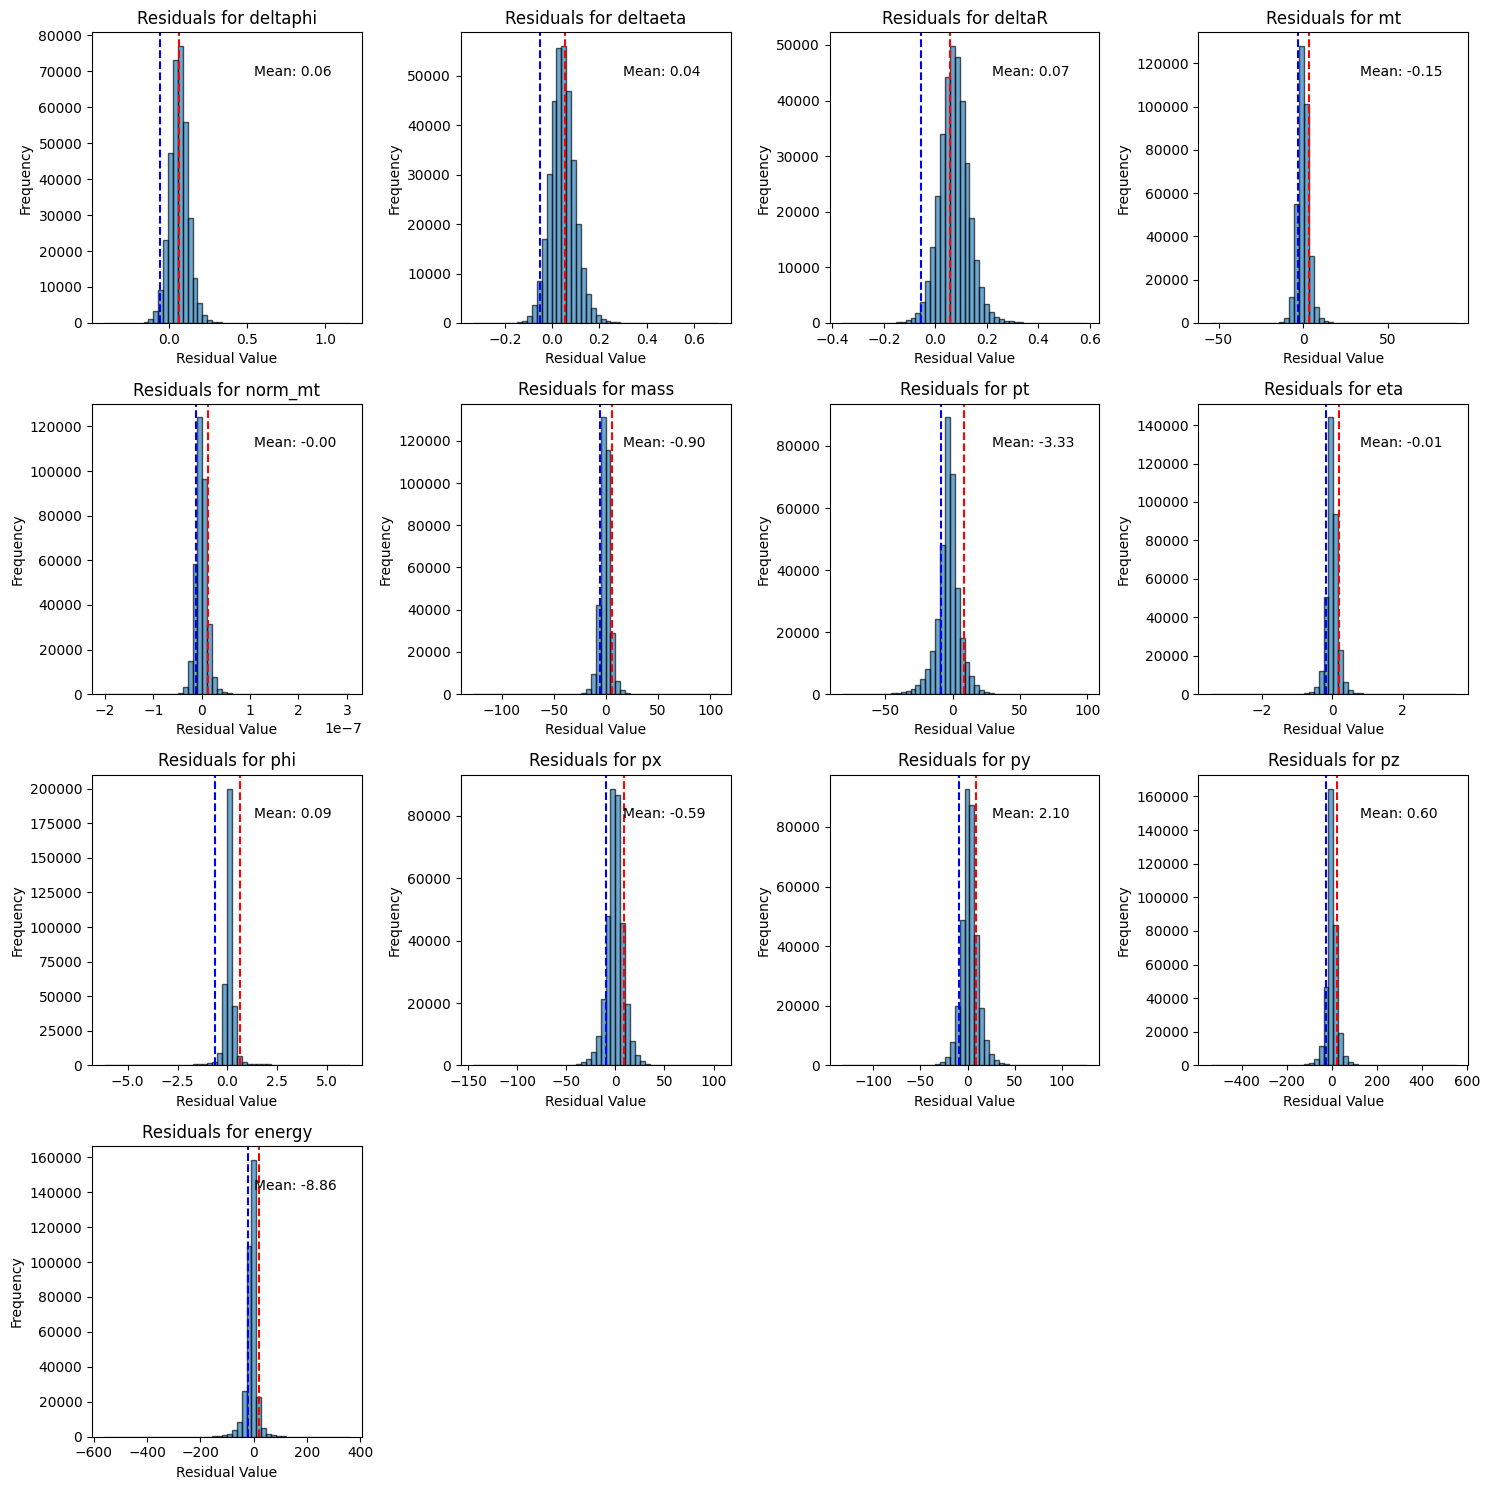

In [12]:
# saved_model = KinematicNet(lenoutput)
model_loc=0
plot_hidden_layer = hidden_layers_list[model_loc]
print('plot_hidden_layer sizes', plot_hidden_layer)
saved_model = CustomKinematicNet(input_size=10, hidden_layers=plot_hidden_layer, lenoutput=lenoutput, activation_fn=F.relu)
saved_model.load_state_dict(saved_models[model_loc])
saved_model.to(device)
saved_model.eval()
# ['deltaphi_12', 'deltaeta_12', 'deltaR_12', 'mt_12', 'norm_mt_12']
out_feats=['deltaphi', 'deltaeta', 'deltaR', 'mt', 'norm_mt', 'mass', 'pt', 'eta' , 'phi',  'px', 'py', 'pz', 'energy']
num_features = n_l_output.shape[2]
residuals = [[] for _ in range(num_features)]
label_values = [[] for _ in range(num_features)]



with torch.no_grad():
    for pair_idx in tqdm(range(len(test_data_list)), desc='Testing', leave=False):
        test_data = test_data_list[pair_idx].to(device)
        test_label = test_labels_list[pair_idx].numpy()  # Convert tensor to numpy
        
        y_pred = saved_model(test_data).cpu().numpy()  # Convert tensor to numpy
        y_pred_inverted = invert_normalize(y_pred, l_output_means[pair_idx, :], l_output_stds[pair_idx, :])
        test_label_inverted = invert_normalize(test_label, l_output_means[pair_idx, :], l_output_stds[pair_idx, :])
        
        residuals_pair = y_pred_inverted - test_label_inverted
        
        for i in range(num_features):
            residuals[i].extend(residuals_pair[:, i])
            label_values[i].extend(test_label_inverted[:, i])


residuals = [np.array(res_list) for res_list in residuals]  # Convert lists of arrays to arrays

residual_std_devs = [np.std(res) for res in residuals]
residual_means = [np.mean(res) for res in residuals]


# print('std_devs length', len(std_devs))

num_rows = 4
num_cols = 4


fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 15))
flat_axes = axes.flatten()

for i, ax in enumerate(flat_axes[:num_features]):
    ax.hist(residuals[i], bins=50, edgecolor='k', alpha=0.65)
    ax.axvline(x=residual_std_devs[i], color='r', linestyle='--', label=f'+1 std (value: {residual_std_devs[i]:.2f})')
    ax.axvline(x=-residual_std_devs[i], color='b', linestyle='--', label=f'-1 std (value: {-residual_std_devs[i]:.2f})')
    ax.set_title(f'Residuals for {out_feats[i]}')
    ax.set_xlabel('Residual Value')
    ax.set_ylabel('Frequency')
    
    # Display the mean value on the plot
    mean_text = f"Mean: {residual_means[i]:.2f}"
    ax.text(0.6, 0.85, mean_text, transform=ax.transAxes)  # Adjust position as needed
    

for ax in flat_axes[num_features:]:
    ax.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
from scipy.stats import anderson

ad_results = []
for i, feature_name in enumerate(out_feats):
    result = anderson(residuals[i])
    ad_results.append({
        'feature': feature_name,
        'statistic': result.statistic,
        'critical_values': result.critical_values,
        'significance_levels': result.significance_level,
        'result': 'Normal' if result.statistic < result.critical_values[2] else 'Not Normal'  # Using 5% significance level
    })
for result in ad_results:
    print('Feature: %s' % result['feature'])
    print('Statistic: %.3f' % result['statistic'])
    for sl, cv in zip(result['significance_levels'], result['critical_values']):
        print('Significance level: %.3f, Critical value: %.3f' % (sl, cv))
    print('Result: %s' % result['result'])
    print()

bin errors for feature pt [6.08822709 0.77186485 0.11499163 0.06617789]
bin errors for feature mt [14.57863856  1.22423535  0.06366473  0.02092288]
bin errors for feature energy [       nan        nan 0.0616923  0.06173856]


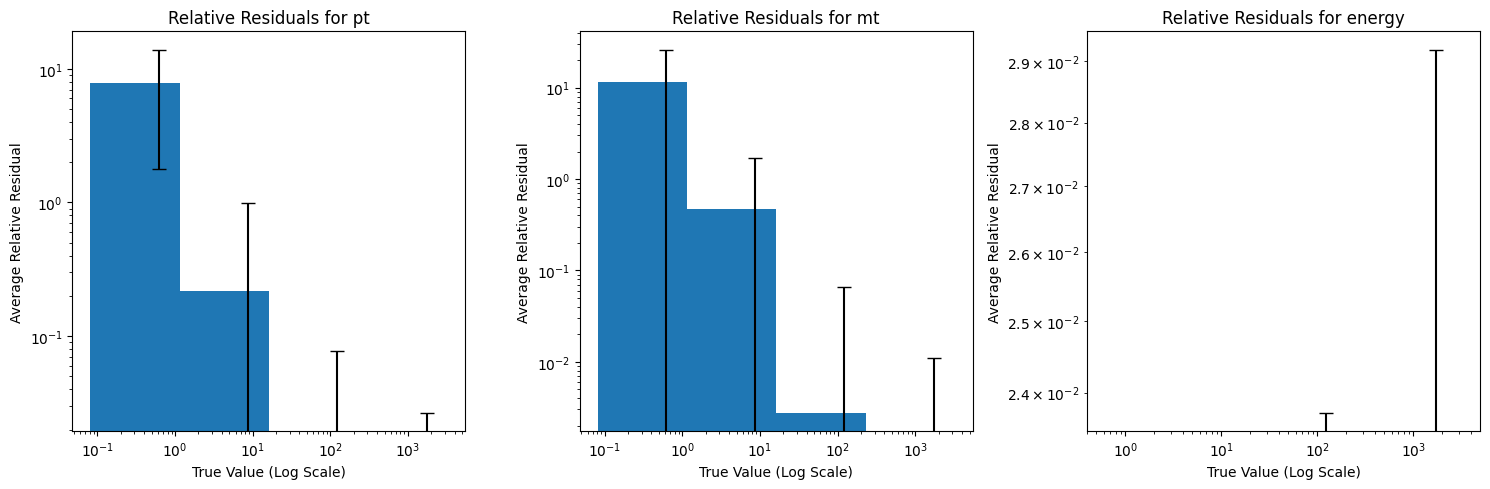

In [13]:
from scipy import stats


selected_features = ['pt', 'mt', 'energy']
selected_indices = [out_feats.index(feat) for feat in selected_features]

# Calculate relative residuals
relative_residuals = [residuals[i] / label_values[i] for i in selected_indices]

# Define logarithmic bins
bins = np.logspace(np.log10(min([min(label_values[i]) for i in selected_indices])),
                   np.log10(max([max(label_values[i]) for i in selected_indices])),
                   num=5)  # 10 bins as an example, adjust as needed

fig, axes = plt.subplots(nrows=1, ncols=len(selected_features), figsize=(15, 5))

for idx, ax in enumerate(axes):
    feature_index = selected_indices[idx]
    # print(relative_residuals[idx])
    # Compute binned statistics (mean and std)
    bin_means, bin_edges, binnumber = stats.binned_statistic(label_values[feature_index],
                                                             relative_residuals[idx],
                                                             statistic='mean',
                                                             bins=bins)
    
    bin_stds, _, _ = stats.binned_statistic(label_values[feature_index],
                                            relative_residuals[idx],
                                            statistic='std',
                                            bins=bins)

    # Compute the widths of the bars
    bar_widths = np.diff(bin_edges)

    print("bin errors for feature", selected_features[idx], bin_stds)
    # Plot the bar plot with error bars
    ax.bar(x=bin_edges[:-1], height=bin_means, width=bar_widths, align='edge', yerr=bin_stds, capsize=5)
    # ax.bar(x=bin_edges[:-1], height=bin_means, width=bar_widths, align='edge', yerr=None, capsize=5)
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title(f'Relative Residuals for {selected_features[idx]}')
    ax.set_xlabel('True Value (Log Scale)')
    ax.set_ylabel('Average Relative Residual')
    # break

plt.tight_layout()
plt.show()


Feature: deltaphi
Statistic: 452.319
Significance level: 15.000, Critical value: 0.576
Significance level: 10.000, Critical value: 0.656
Significance level: 5.000, Critical value: 0.787
Significance level: 2.500, Critical value: 0.918
Significance level: 1.000, Critical value: 1.092
Result: Not Normal

Feature: deltaeta
Statistic: 393.590
Significance level: 15.000, Critical value: 0.576
Significance level: 10.000, Critical value: 0.656
Significance level: 5.000, Critical value: 0.787
Significance level: 2.500, Critical value: 0.918
Significance level: 1.000, Critical value: 1.092
Result: Not Normal

Feature: deltaR
Statistic: 435.760
Significance level: 15.000, Critical value: 0.576
Significance level: 10.000, Critical value: 0.656
Significance level: 5.000, Critical value: 0.787
Significance level: 2.500, Critical value: 0.918
Significance level: 1.000, Critical value: 1.092
Result: Not Normal

Feature: mt
Statistic: 1731.810
Significance level: 15.000, Critical value: 0.576
Signific

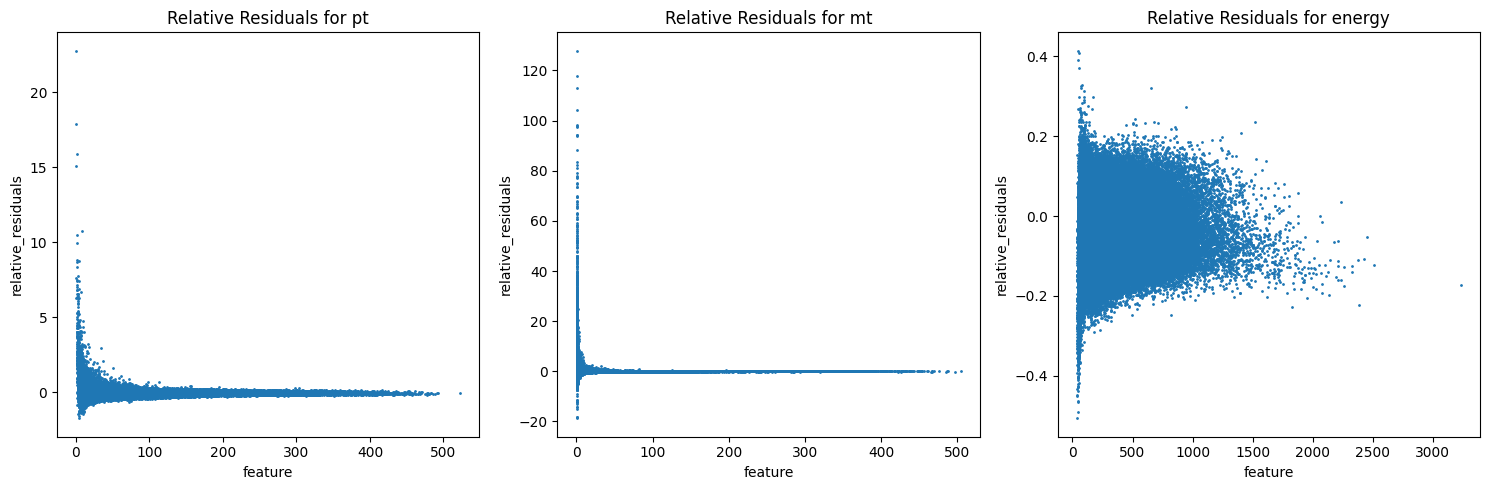

In [15]:
selected_features = ['pt', 'mt', 'energy']
selected_indices = [out_feats.index(feat) for feat in selected_features]

# Calculate relative residuals
relative_residuals = [residuals[i] / label_values[i] for i in selected_indices]

# Plot the histograms
fig, axes = plt.subplots(nrows=1, ncols=len(selected_features), figsize=(15, 5))

for i, ax in enumerate(axes):
    ax.scatter(label_values[selected_indices[i]], relative_residuals[i], s=1)
    ax.set_title(f'Relative Residuals for {selected_features[i]}')
    ax.set_xlabel('feature')
    ax.set_ylabel('relative_residuals')

plt.tight_layout()
plt.show()
